In [1]:
import pandas as pd
import requests
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.charts import Bar
from pyecharts.charts import Geo
from pyecharts.charts import Scatter
from pyecharts.charts import Map

API_KEYS = ['f6e3c70955315533270eade055626bd9','589ae89e034692656e66f2e728c3df0d'] #单账号配额5000

In [2]:
def request_with_api_key(location, api_key):
    location_str = "{},{}".format(location[0], location[1])
    url = 'https://restapi.amap.com/v3/geocode/regeo?'
    params = {
        'location': location_str,
        'key': api_key,
        'extensions': 'base',
        'output': 'JSON',
        'roadlevel': 0,
    }
    r = requests.get(url, params=params)
    data = r.json().get('regeocode', {})
    city = data.get('addressComponent', {}).get('city', '')
    province = data.get('addressComponent', {}).get('province', '')
    if not city:
        city = province
    return city, province

def latitude_longitude_conversion(df, api_keys):
    city_province_list = []  # 存储城市和省份的临时列表
    for location in df[['lon', 'lat']].values:
        for api_key in api_keys:
            city, province = request_with_api_key(location, api_key)
            if city or province:  # 如果成功获取到城市或省份信息，则跳出循环
                break
        city_province_list.append((city, province))

    cities, provinces = zip(*city_province_list)  # 解压城市和省份列表
    df['city'] = cities  # 添加城市列
    df['province'] = provinces  # 添加省份列
    
    return df

In [3]:
data = pd.read_excel("./china3.xls")
data.columns = ["id", "date", "lon", "lat", "depth", "type", "level", "loc", "incident"]
print(data.shape, "\n", data.dtypes)

(107, 9) 
 id                   int64
date        datetime64[ns]
lon                float64
lat                float64
depth                int64
type                object
level              float64
loc                 object
incident            object
dtype: object


In [4]:
x = data.isnull().sum().sum()
print('共有NaN:', x)

共有NaN: 0


In [5]:
x = data.duplicated().sum()
print('共有重复行:', x)

共有重复行: 0


In [ ]:
data = latitude_longitude_conversion(data, API_KEYS)
data.to_csv('china_new.csv', index=False)

In [31]:
data = pd.read_csv("./china_new.csv")
print(data.head())

   id                 date     lon    lat  depth type  level     loc incident   
0   1  2022-09-30 22:37:19  121.40  22.77     19   Ms    4.4  台湾台东海域     天然地震  \
1   2  2022-09-29 18:48:11   78.41  41.02     11   ML    3.5   新疆阿合奇     天然地震   
2   3  2022-09-29 17:30:45   77.75  37.64     25   ML    3.8    新疆皮山     天然地震   
3   4  2022-09-28 11:57:12  107.46  24.34      6   ML    3.8    广西东兰     天然地震   
4   5  2022-09-27 19:54:53  115.07  22.48     21   ML    3.2  广东惠东海域     天然地震   

          city  province  
0      中华人民共和国   中华人民共和国  
1  克孜勒苏柯尔克孜自治州  新疆维吾尔自治区  
2         和田地区  新疆维吾尔自治区  
3          河池市   广西壮族自治区  
4      中华人民共和国   中华人民共和国  


In [32]:
# 根据地区信息筛选出地震级别大于等于4.5的地震事件
strong_quakes = data[data['level'] >= 4.5]

In [33]:
# 统计每个地区发生强震的次数
data = pd.read_csv("./china_new.csv")
strong_quakes = data[data['level'] >= 4.5]
quake_counts = strong_quakes['city'].value_counts().reset_index()
quake_counts.columns = ['city', 'count']

# 生成词云图
wordcloud = (
    WordCloud()
    .add("", quake_counts.values.tolist(), word_size_range=[20, 100])
    .set_global_opts(title_opts=opts.TitleOpts(title="12年内各地区发生强震次数词云图"))
)

# 保存词云图
wordcloud.render("earthquake_wordcloud.html")

'D:\\code\\py\\earthquake_wordcloud.html'

NameError: name 'province_lon' is not defined

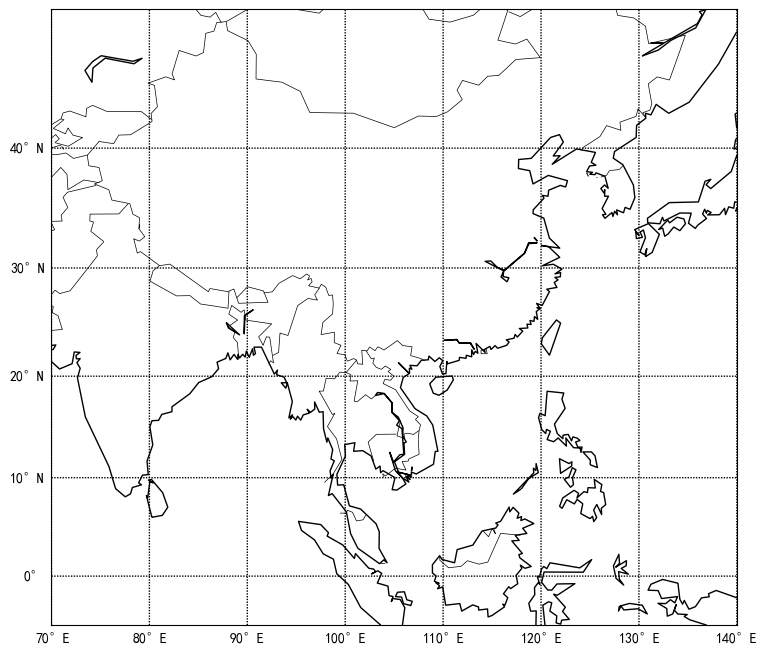

In [92]:
# 统计每个省份发生强震的次数
data = pd.read_csv("./china_new.csv")
strong_quakes = data[data['level'] >= 4.5]
quake_counts = strong_quakes['province'].value_counts().reset_index()
quake_counts.columns = ['province', 'count']

# 获取省份名称和对应的强震次数
provinces = quake_counts['province'].tolist()
counts = quake_counts['count'].tolist()

# 去掉“中华人民共和国”这个点
if "中华人民共和国" in provinces:
    index = provinces.index("中华人民共和国")
    provinces.pop(index)
    counts.pop(index)
# 去掉“[]”这个点
if "[]" in provinces:
    index = provinces.index("[]")
    provinces.pop(index)
    counts.pop(index)

print(provinces)
print(counts)

# 绘制地图
china_geo = (
    Geo(is_ignore_nonexistent_coord=True)
    .add_schema(maptype="china")
    .add("大于4.5级地震次数", [list(z) for z in zip(provinces, counts)], type_= "heatmap")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(max_=max(counts), is_piecewise=True),
        title_opts=opts.TitleOpts(title="中国各省份大于4.5级地震次数分布图"),
    )
)

# 保存地图
china_geo.render("earthquake_geo.html")

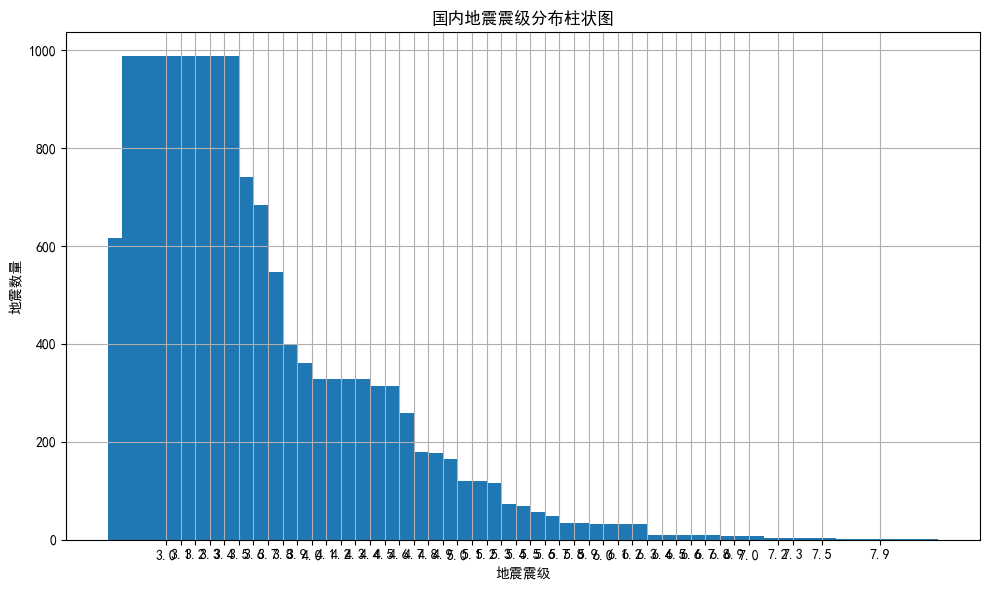

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("./china_new.csv")

# 统计不同震级的数量
strong_quakes = data[data['level'] >= 4.5]
level_counts = data['level'].value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(level_counts.index, level_counts.values)
plt.title('国内地震震级分布柱状图')
plt.xlabel('地震震级')
plt.ylabel('地震数量')
plt.xticks(level_counts.index)
plt.grid(True)
plt.tight_layout()

# 保存柱状图
plt.savefig("earthquake_bar.png")
plt.show()

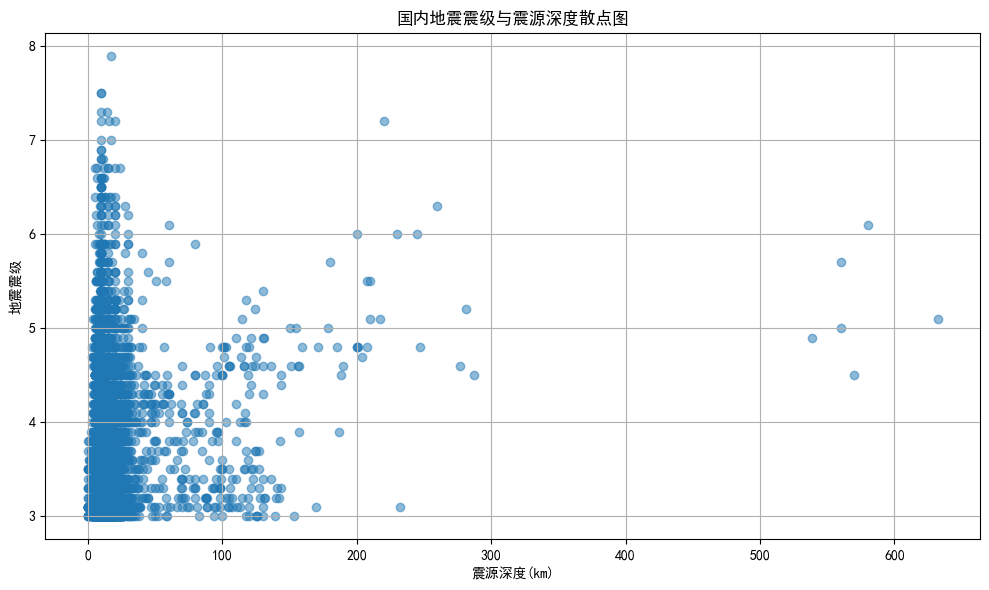

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("./china_new.csv")

# 提取国内地震的震级和震源深度信息
strong_quakes = data[data['level'] >= 4.5]
earthquake_levels = data['level']
earthquake_depths = data['depth']

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(earthquake_depths, earthquake_levels, alpha=0.5)
plt.title('国内地震震级与震源深度散点图')
plt.xlabel('震源深度(km)')
plt.ylabel('地震震级')
plt.grid(True)
plt.tight_layout()

# 保存散点图
plt.savefig("earthquake_scatter.png")
plt.show()

In [82]:
from pyecharts import options as opts
from pyecharts.charts import Map
from collections import Counter
import pandas as pd

# 读取数据
data = pd.read_csv("./china_new.csv")

# 提取地震的省份列名
province_column = 'province'

# 提取地震的省份信息
earthquake_province = data[province_column]

# 计算每个省份的出现次数
province_counts = Counter(earthquake_province)

# 获取省份名称和地震次数
provinces = list(province_counts.keys())
counts = list(province_counts.values())

# 准备数据
data_pair = [(province, count) for province, count in zip(provinces, counts)]

# 绘制地图
map_chart = (
    Map()
    .add("地震次数", data_pair, "china")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="中国各省地震次数热力图"),
        visualmap_opts=opts.VisualMapOpts(max_=max(counts)),
    )
)

# 渲染图表
map_chart.render("china_earthquake_heatmap.html")

'D:\\code\\py\\china_earthquake_heatmap.html'

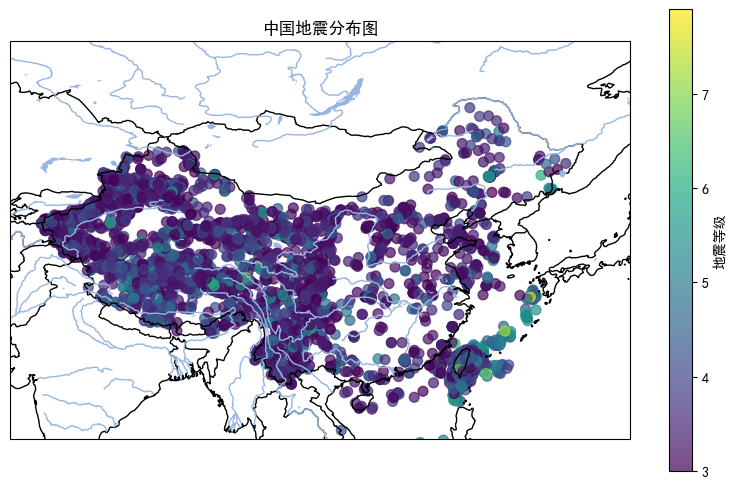

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 读取数据
data = pd.read_csv("./china_new.csv")

# 获取地震数据
earthquake_data = list(zip(data['lon'], data['lat'], data['level']))

# 提取经纬度信息
lon = [item[0] for item in earthquake_data]
lat = [item[1] for item in earthquake_data]
level = [item[2] for item in earthquake_data]

# 创建地图
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 140, 15, 55])  # 设置地图范围

# 添加中国地图背景
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))

# 绘制地震散点图
sc = ax.scatter(lon, lat, c=level, cmap='viridis', s=50, alpha=0.7, transform=ccrs.PlateCarree())

# 添加标题和颜色条
plt.colorbar(sc, label='地震等级')
plt.title('中国地震分布图')

# 显示图形
plt.show()

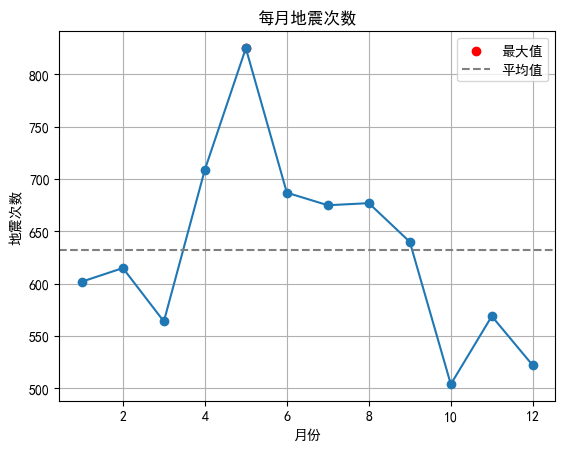

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

# 读取数据
data = pd.read_csv("./china_new.csv")

# 将日期时间列转换为日期时间格式
data["date"] = pd.to_datetime(data["date"])

# 提取月份信息并计算每个月的地震次数
data["month"] = data["date"].dt.month
monthly_counts = data["month"].value_counts().sort_index()

# 生成x轴和y轴数据
x_data = list(monthly_counts.index)
y_data = list(monthly_counts.values)

# 使用Matplotlib绘制曲线图
plt.plot(x_data, y_data, marker='o', linestyle='-')

# 添加标签和标题
plt.title('每月地震次数')
plt.xlabel('月份')
plt.ylabel('地震次数')

# 添加标记点和平均线
max_value = max(y_data)
average_value = sum(y_data) / len(y_data)
plt.scatter(x_data[y_data.index(max_value)], max_value, color='red', label='最大值')
plt.axhline(y=average_value, color='gray', linestyle='--', label='平均值')

# 显示图例
plt.legend()

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()

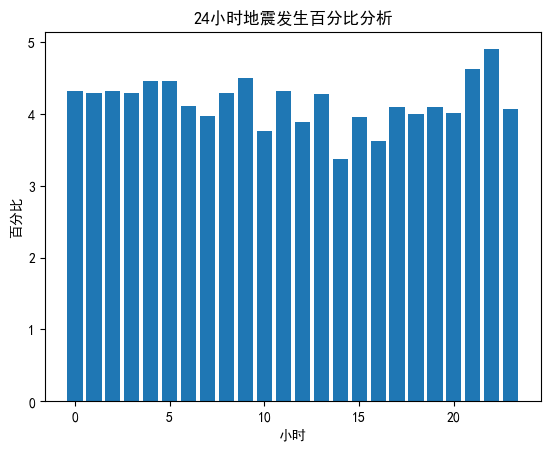

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("./china_new.csv")

# 将时间列转换为日期时间格式
data["date"] = pd.to_datetime(data["date"])

# 提取小时信息并计算每个小时的地震次数
data["hour"] = data["date"].dt.hour
hourly_counts = data["hour"].value_counts().sort_index()

# 计算每个小时的地震百分比
total_earthquakes = len(data)
hourly_percentages = (hourly_counts / total_earthquakes) * 100

# 绘制柱状图
plt.bar(hourly_percentages.index, hourly_percentages.values)

# 添加标题和标签
plt.title('24小时地震发生百分比分析')
plt.xlabel('小时')
plt.ylabel('百分比')

# 显示图形
plt.show()

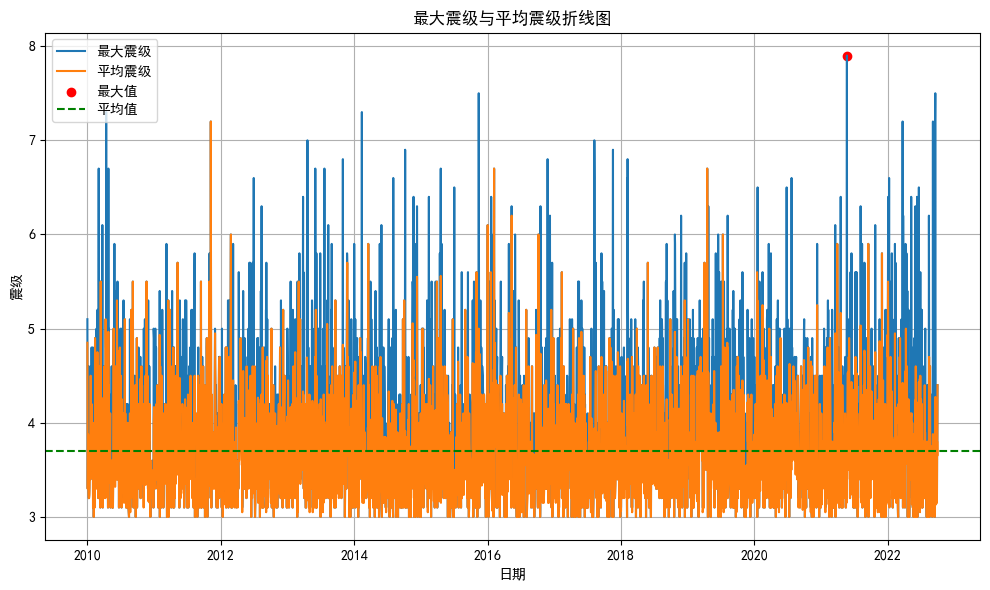

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("./china_new.csv")

# 将日期时间列转换为日期
data["date"] = pd.to_datetime(data["date"])

# 计算每个日期的最大震级和平均震级
daily_max_magnitude = data.groupby(data["date"].dt.date)["level"].max()
daily_avg_magnitude = data.groupby(data["date"].dt.date)["level"].mean()

# 提取日期数据和震级数据
dates = list(daily_max_magnitude.index)
max_magnitudes = list(daily_max_magnitude.values)
avg_magnitudes = list(daily_avg_magnitude.values)

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(dates, max_magnitudes, label='最大震级')
plt.plot(dates, avg_magnitudes, label='平均震级')

# 添加标记点和标记线
plt.scatter(dates[max_magnitudes.index(max(max_magnitudes))], max(max_magnitudes), color='red', label='最大值')
plt.axhline(y=sum(avg_magnitudes) / len(avg_magnitudes), color='green', linestyle='--', label='平均值')

# 添加标题和图例
plt.title('最大震级与平均震级折线图')
plt.xlabel('日期')
plt.ylabel('震级')
plt.legend()

# 显示图形
plt.grid(True)
plt.tight_layout()
plt.show()

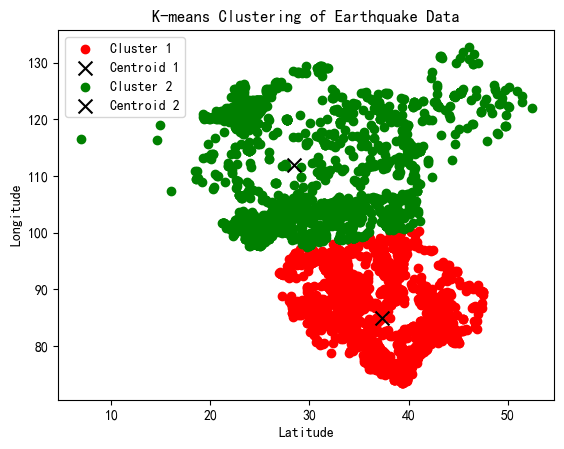

In [89]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 假设你有一个包含地震数据的二维数组，每行代表一个地震事件，包括地理位置和震级特征
# 你需要根据你的实际数据进行相应的处理和准备
earthquake_data=data[['lat', 'lon', 'level']].values

# 假设你已经准备好了地震数据，接下来可以使用K-means算法进行聚类分析
# 假设我们设定聚类数量为2，你可以根据你的数据进行调整
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
kmeans.fit(earthquake_data)

# 获取聚类中心和每个样本的所属簇标签
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# 绘制聚类结果
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i in range(num_clusters):
    cluster_data = earthquake_data[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], label=f'Cluster {i+1}')
    plt.scatter(centroids[i][0], centroids[i][1], marker='x', c='black', s=100, label=f'Centroid {i+1}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('K-means Clustering of Earthquake Data')
plt.legend()
plt.show()